# 1) Feature Selection

## a) Load Libraries & Datasets

In [1]:
!pip install darts
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 24.5 MB/s eta 0:00

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
%matplotlib inline

import shap
import pickle
import random
import tensorflow as tf
from scipy.interpolate import interp1d
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from pytorch_lightning.callbacks import Callback
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, Add, GlobalAveragePooling1D, MultiHeadAttention, Conv1D


from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (gaussian_timeseries, linear_timeseries, sine_timeseries)
from darts.models import (RNNModel, TCNModel, TransformerModel, NBEATSModel, TFTModel, XGBModel)
from darts.metrics import mape, rmse, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import logging
logging.disable(logging.CRITICAL)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df_bbca = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBCA.csv')
df_bbni = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBNI.csv')
df_bbri = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBRI.csv')
df_bmri = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BMRI.csv')
df_mega = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_MEGA.csv')

# Define datasets
dfs = [df_bbca, df_bbni, df_bbri, df_bmri, df_mega]
labels = ['BBCA', 'BBNI', 'BBRI', 'BMRI', 'MEGA']
labels_c0 = ['BBCA', 'BBNI', 'BMRI']
labels_c1 = ['BBRI', 'MEGA']

Mounted at /content/drive


## b) Feature Selection using Shapley

In [4]:
def compute_shapley_importances_transformer(df, drop_cols=['Date']):
    random.seed(1)
    np.random.seed(1)
    tf.random.set_seed(1)

    # Scale the entire dataset
    scaler = MinMaxScaler()
    df_temp = df.drop(columns=drop_cols)
    scaled_data = scaler.fit_transform(df_temp)

    # Convert to DataFrame for convenience
    scaled_df = pd.DataFrame(scaled_data, columns=df_temp.columns)

    # Define target (Close) and features
    target = 'Close'
    features = [col for col in scaled_df.columns if col != target]
    X = scaled_df[features].values
    y = scaled_df[target].values

    # Create sequences for time-series modeling
    def create_sequences(X, y, seq_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_length):
            X_seq.append(X[i:i+seq_length])
            y_seq.append(y[i+seq_length])
        return np.array(X_seq), np.array(y_seq)

    SEQ_LENGTH = 24  # Example: 24 time steps
    X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)

    # Train-Test split while preserving temporal order
    train_size = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]

    # Encoder Layer
    def transformer_encoder(inputs, num_heads, embed_dim, ff_dim, dropout_rate=0.1):
        attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
        attention_output = Add()([inputs, attention])
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
        ffn = Dense(ff_dim, activation='relu')(attention_output)
        ffn = Dense(embed_dim)(ffn)
        ffn_output = Add()([attention_output, ffn])
        ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        return ffn_output

    # Decoder Layer
    def transformer_decoder(inputs, encoder_output, num_heads, embed_dim, ff_dim, dropout_rate=0.1):
        attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
        attention_output = Add()([inputs, attention])
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
        # Cross-attention with encoder output (Decoder attends to Encoder)
        cross_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(attention_output, encoder_output)
        cross_attention_output = Add()([attention_output, cross_attention])
        cross_attention_output = LayerNormalization(epsilon=1e-6)(cross_attention_output)
        ffn = Dense(ff_dim, activation='relu')(cross_attention_output)
        ffn = Dense(embed_dim)(ffn)
        ffn_output = Add()([cross_attention_output, ffn])
        ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        return ffn_output

    # Build the full Transformer model
    OUTPUT_LENGTH = 1
    embed_dim = len(features)
    num_heads = 4
    ff_dim = 512
    dropout_rate = 0.1

    inputs = Input(shape=(SEQ_LENGTH, embed_dim))  # Assuming input features match embed_dim

    # Encoder: 3 encoder layers (as per Darts model)
    x = Dense(embed_dim, activation='relu')(inputs)
    for _ in range(3):  # 3 encoder layers (as per Darts model)
        x = transformer_encoder(x, num_heads, embed_dim, ff_dim, dropout_rate)

    # Decoder: 3 decoder layers (as per Darts model)
    decoder_inputs = Input(shape=(SEQ_LENGTH, embed_dim))  # Decoder input matches output length
    decoder_output = decoder_inputs
    for _ in range(3):  # 3 decoder layers
        decoder_output = transformer_decoder(decoder_output, x, num_heads, embed_dim, ff_dim, dropout_rate)

    # Output layer
    x = Dense(embed_dim, activation='relu')(decoder_output)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(OUTPUT_LENGTH)(x)  # Predicting sequence output of length OUTPUT_LENGTH

    # Build the model
    model = Model(inputs=[inputs, decoder_inputs], outputs=outputs)

    # Compile and train the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit([X_train, X_train], y_train, epochs=100, batch_size=8, validation_data=([X_test, X_test], y_test), verbose=0)

    # Reshape X_test and X_train to 2D for SHAP
    X_test_2d = X_test.reshape(X_test.shape[0], -1)[:10]  # Flatten sequences
    X_train_2d = X_train.reshape(X_train.shape[0], -1)[:100]  # Use subset for efficiency

    # Adjust SHAP for the model
    def predict_fn(X):
        X_reshaped = X.reshape(X.shape[0], SEQ_LENGTH, embed_dim)  # Reshape back for the model
        return model.predict([X_reshaped, X_reshaped]).flatten()

    # SHAP KernelExplainer
    explainer = shap.KernelExplainer(predict_fn, X_train_2d)  # Convert to NumPy for SHAP if needed
    shap_values = explainer.shap_values(X_test_2d)  # Ensure SHAP receives NumPy arrays

    # Aggregate mean absolute Shapley values per feature
    feature_importances = pd.DataFrame({
        'Feature': features * SEQ_LENGTH,  # Repeat features for all time steps
        'Importance': np.mean(np.abs(shap_values), axis=0)
    })
    return feature_importances

In [5]:
# USING Transformer

# Compute Shapley values for all datasets and combine into a single DataFrame
all_importances = []
for df, label in zip(dfs, labels):
    importances = compute_shapley_importances_transformer(df)
    importances = importances.rename(columns={'Importance': label})
    importances = importances.set_index('Feature')
    all_importances.append(importances)

# Combine all importances into a single DataFrame
combined_importances = pd.concat(all_importances, axis=1)
combined_importances = combined_importances.groupby('Feature').mean()
combined_importances['Average (Cluster 0)'] = abs(combined_importances[['BBCA','BBNI','BMRI']].mean(axis=1))
combined_importances['Average (Cluster 1)'] = abs(combined_importances[['BBRI','MEGA']].mean(axis=1))
combined_importances.reset_index(inplace=True)
combined_importances

Feature      BBCA      BBNI      BBRI      BMRI      MEGA  \
0                 DER  0.005313  0.004714  0.002235  0.000000  0.000000   
1                 EPS  0.005803  0.001858  0.002120  0.008146  0.000981   
2                 FAT  0.005243  0.001655  0.006548  0.003429  0.001818   
3                 PBV  0.005492  0.004159  0.001763  0.006277  0.002913   
4                 PER  0.006272  0.002294  0.004104  0.004715  0.000370   
5                 PTS  0.007986  0.009974  0.002891  0.003104  0.000471   
6                ROA%  0.005404  0.003609  0.003447  0.003351  0.000473   
7                ROE%  0.006808  0.001863  0.002775  0.003311  0.000869   
8    is_first_2_weeks  0.006090  0.001599  0.001868  0.003172  0.003399   
9       is_idul_fitri  0.006139  0.002740  0.002226  0.002992  0.001574   
10  is_ramadhan_start  0.005815  0.002249  0.002250  0.002684  0.000591   

    Average (Cluster 0)  Average (Cluster 1)  
0              0.003342             0.001118  
1              0.005269             0.001551  
2              0.003442             0.004183  
3              0.005309             0.002338  
4              0.004427             0.002237  
5              0.007021             0.001681  
6              0.004121             0.001960  
7              0.003994             0.001822  
8              0.003620             0.002633  
9              0.003957             0.001900  
10             0.003583             0.001420

Selected Features for Cluster 0: ['PTS' 'PBV' 'EPS' 'PER'], Threshold: 0.00437
Selected Features for Cluster 1: ['FAT' 'is_first_2_weeks' 'PBV' 'PER'], Threshold: 0.00208


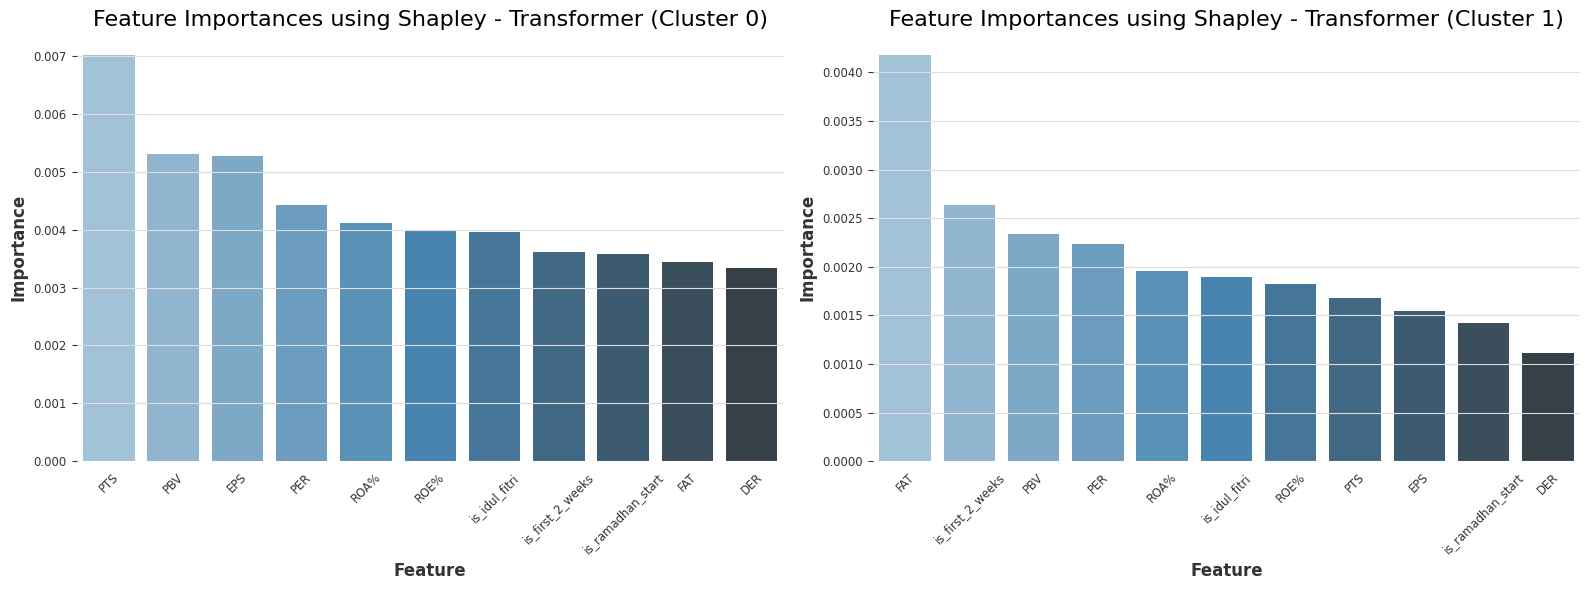

In [6]:
df_sorted = combined_importances.sort_values(by="Average (Cluster 0)", ascending=False).reset_index(drop=True)
threshold_c0 = df_sorted['Average (Cluster 0)'].mean()
selected_features_c0 = df_sorted[df_sorted['Average (Cluster 0)'] > threshold_c0]['Feature'].values

df_sorted = combined_importances.sort_values(by="Average (Cluster 1)", ascending=False).reset_index(drop=True)
threshold_c1 = df_sorted['Average (Cluster 1)'].mean()
selected_features_c1 = df_sorted[df_sorted['Average (Cluster 1)'] > threshold_c1]['Feature'].values

print(f'Selected Features for Cluster 0: {selected_features_c0}, Threshold: {round(threshold_c0, 5)}')
print(f'Selected Features for Cluster 1: {selected_features_c1}, Threshold: {round(threshold_c1, 5)}')


# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feature Importances - Average (Cluster 0)
temp = combined_importances.sort_values(by='Average (Cluster 0)', ascending=False)
sns.barplot(x='Feature', y='Average (Cluster 0)', data=temp, palette="Blues_d", ax=axes[0])
axes[0].set_title("Feature Importances using Shapley - Transformer (Cluster 0)", fontsize=16)
axes[0].set_xlabel("Feature", fontsize=12)
axes[0].set_ylabel("Importance", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Feature Importances - Average (Cluster 1)
temp = combined_importances.sort_values(by='Average (Cluster 1)', ascending=False)
sns.barplot(x='Feature', y='Average (Cluster 1)', data=temp, palette="Blues_d", ax=axes[1])
axes[1].set_title("Feature Importances using Shapley - Transformer (Cluster 1)", fontsize=16)
axes[1].set_xlabel("Feature", fontsize=12)
axes[1].set_ylabel("Importance", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show combined plot
plt.show()

# 2) Data Preprocessing

In [7]:
def data_preprocessing(df, columns):
    # Convert all variables to TimeSeries format
    price = TimeSeries.from_values(df['Close'])
    time_series_data = {col: TimeSeries.from_values(df[col]) for col in columns}

    # Stack the fundamental data to obtain series of 2 dimensions
    covariates = time_series_data[columns[0]]  # Start with 'PER' as the base
    for col in columns[1:]:  # Skip the first column since it's already included
        covariates = covariates.stack(time_series_data[col])

    # Split the covariates into training and validation sets
    train_covariates, val_covariates = covariates[:-split], covariates[-split:]

    # Scale the covariates between 0 and 1
    scaler_covariates = Scaler()
    train_covariates = scaler_covariates.fit_transform(train_covariates)
    val_covariates = scaler_covariates.transform(val_covariates)

    # Concatenate the scaled results for model input
    covariates = concatenate([train_covariates, val_covariates])

    # Scale the price data
    scaler_price = Scaler()
    price_scaled = scaler_price.fit_transform(price)
    train_df, val_df = price_scaled[:-split], price_scaled[-split:]

    return train_df, val_df, covariates, scaler_price, price_scaled

In [8]:
split = 36 # splitting point (prediksi 36 minggu ke depan)

fund_columns_all = ['PER', 'FAT', 'PTS', 'EPS', 'PBV', 'DER', 'ROE%', 'ROA%', 'is_first_2_weeks', 'is_idul_fitri', 'is_ramadhan_start']
fund_columns_c0 = ['PER', 'PTS', 'EPS', 'PBV']
fund_columns_c1 = ['PER', 'FAT', 'PBV', 'is_first_2_weeks']

In [9]:
train_bbca, val_bbca, covariates_bbca, scaler_bbca, price_bbca = data_preprocessing(df_bbca, fund_columns_c0)
train_bbni, val_bbni, covariates_bbni, scaler_bbni, price_bbni = data_preprocessing(df_bbni, fund_columns_c0)
train_bbri, val_bbri, covariates_bbri, scaler_bbri, price_bbri = data_preprocessing(df_bbri, fund_columns_c1)
train_bmri, val_bmri, covariates_bmri, scaler_bmri, price_bmri = data_preprocessing(df_bmri, fund_columns_c0)
train_mega, val_mega, covariates_mega, scaler_mega, price_mega = data_preprocessing(df_mega, fund_columns_c1)

train_lists_c0 = [train_bbca, train_bbni, train_bmri]
val_lists_c0 = [val_bbca, val_bbni, val_bmri]
covariates_lists_c0 = [covariates_bbca, covariates_bbni, covariates_bmri]
scalers_lists_c0 = [scaler_bbca, scaler_bbni, scaler_bmri]
price_lists_c0 = [price_bbca, price_bbni, price_bmri]
df_lists_c0 = [df_bbca, df_bbni, df_bmri]

train_lists_c1 = [train_bbri, train_mega]
val_lists_c1 = [val_bbri, val_mega]
covariates_lists_c1 = [covariates_bbri, covariates_mega]
scalers_lists_c1 = [scaler_bbri, scaler_mega]
price_lists_c1 = [price_bbri, price_mega]
df_lists_c1 = [df_bbri, df_mega]

In [10]:
train_bbca, val_bbca, covariates_bbca, scaler_bbca, price_bbca = data_preprocessing(df_bbca, fund_columns_all)
train_bbni, val_bbni, covariates_bbni, scaler_bbni, price_bbni = data_preprocessing(df_bbni, fund_columns_all)
train_bbri, val_bbri, covariates_bbri, scaler_bbri, price_bbri = data_preprocessing(df_bbri, fund_columns_all)
train_bmri, val_bmri, covariates_bmri, scaler_bmri, price_bmri = data_preprocessing(df_bmri, fund_columns_all)
train_mega, val_mega, covariates_mega, scaler_mega, price_mega = data_preprocessing(df_mega, fund_columns_all)

train_lists_c0_all = [train_bbca, train_bbni, train_bmri]
val_lists_c0_all = [val_bbca, val_bbni, val_bmri]
covariates_lists_c0_all = [covariates_bbca, covariates_bbni, covariates_bmri]
scalers_lists_c0_all = [scaler_bbca, scaler_bbni, scaler_bmri]
price_lists_c0_all = [price_bbca, price_bbni, price_bmri]
df_lists_c0_all = [df_bbca, df_bbni, df_bmri]

train_lists_c1_all = [train_bbri, train_mega]
val_lists_c1_all = [val_bbri, val_mega]
covariates_lists_c1_all = [covariates_bbri, covariates_mega]
scalers_lists_c1_all = [scaler_bbri, scaler_mega]
price_lists_c1_all = [price_bbri, price_mega]
df_lists_c1_all = [df_bbri, df_mega]

# 3) Modeling

## a) Define Functions

In [11]:
# predict model using past covariates
def predict_pastcov(train_data, val_data, model, scaler, stock_name, covariates, df, model_name):
    pred_cov = model.predict(n=36, series=train_data, past_covariates=covariates)  # Prediction 36 timestamps forward from the last training data
    pred_cov_inverse = scaler.inverse_transform(pred_cov)  # Inverse transform the scaled data
    val_inverse = scaler.inverse_transform(val_data)  # Inverse transform the validation data

    # Plot the actual and predicted values
    plt.figure(figsize=(7, 4))
    plt.plot(pd.to_datetime(df['Date']), df['Close'], label="Actual")
    plt.plot(pd.to_datetime(df['Date'][-len(pred_cov_inverse):]), pred_cov_inverse.values(), label="Forecast")

    # Add legend and labels
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock Price')

    # Calculate metrics: MAPE, MAE, RMSE
    mape_score = round(mape(val_inverse, pred_cov_inverse), 2)
    mae_score = round(mae(val_inverse, pred_cov_inverse), 2)
    rmse_score = round(rmse(val_inverse, pred_cov_inverse), 2)

    # Display the metrics in the title
    plt.title(f'{stock_name} - {model_name}\nMAPE = {mape_score}%, MAE = {mae_score}, RMSE = {rmse_score}')
    plt.show()

In [12]:
# predict model using no covariates
def predict_nocov(train_data, val_data, model, scaler, stock_name, df, model_name):
    pred_cov = model.predict(n=36, series=train_data) # Prediction 36 timestamps forward from the last training data
    pred_cov_inverse = scaler.inverse_transform(pred_cov) # Inverse transform the scaled data
    val_inverse = scaler.inverse_transform(val_data)

    # Plot the actual and predicted values
    plt.figure(figsize=(7, 4))
    plt.plot(pd.to_datetime(df['Date']), df['Close'], label="actual")
    plt.plot(pd.to_datetime(df['Date'][-len(pred_cov_inverse):]), pred_cov_inverse.values(), label="forecast")

    # Add legend and labels
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock Price')

    # Calculate metrics: MAPE, MAE, RMSE
    mape_score = round(mape(val_inverse, pred_cov_inverse), 2)
    mae_score = round(mae(val_inverse, pred_cov_inverse), 2)
    rmse_score = round(rmse(val_inverse, pred_cov_inverse), 2)

    # Display the metrics in the title
    plt.title(f'{stock_name} - {model_name}\nMAPE = {mape_score}%, MAE = {mae_score}, RMSE = {rmse_score}')
    plt.show()

In [13]:
# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

## b) Model Training - Cluster 0

#### 1) With All Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

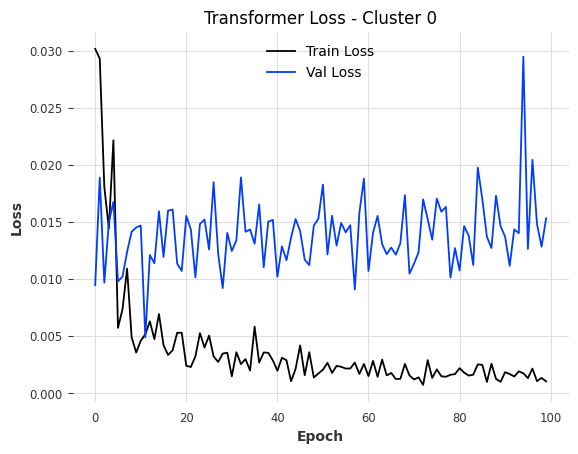

In [14]:
class LossRecorder_transformer(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_transformer = LossRecorder_transformer()


model_name = "Transformer_test"
model_transformer = TransformerModel(
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_transformer]}
    # **generate_torch_kwargs()
)

model_transformer.fit(
    series=train_lists_c0_all,
    past_covariates=covariates_lists_c0_all,
    val_series=val_lists_c0_all,
    val_past_covariates=covariates_lists_c0_all,
)

model_transformer = TransformerModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_transformer.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_transformer.val_loss_history, label='Val Loss')
plt.title('Transformer Loss - Cluster 0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
model_transformer

TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, batch_size=8, n_epochs=100, random_state=1, input_chunk_length=24, output_chunk_length=12, model_name=Transformer_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossRecorder_transformer object at 0x7fe8359b7a60>]})

Predicting: |          | 0/? [00:00<?, ?it/s]

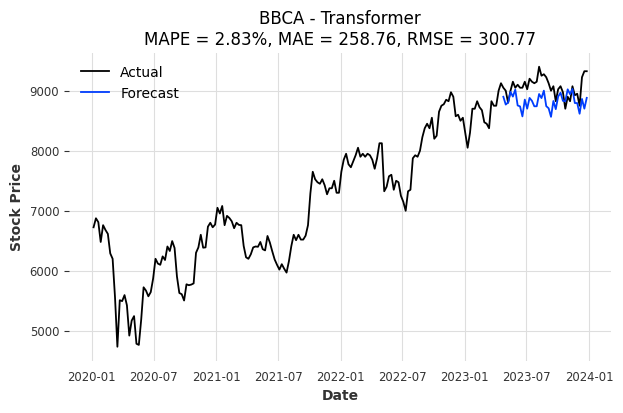

Predicting: |          | 0/? [00:00<?, ?it/s]

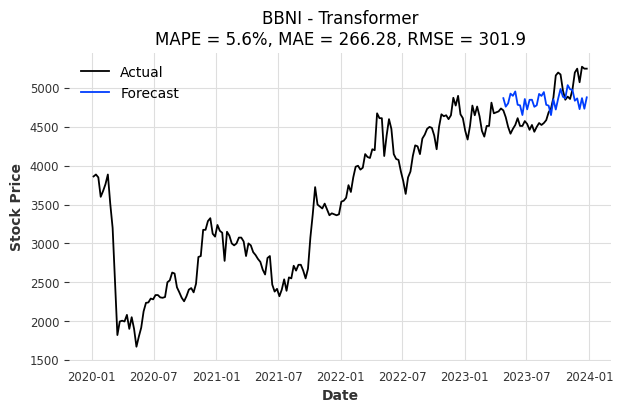

Predicting: |          | 0/? [00:00<?, ?it/s]

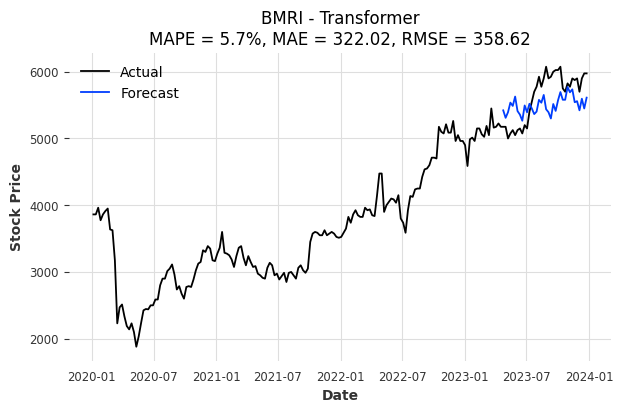

In [16]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c0_all, val_lists_c0_all, scalers_lists_c0_all, labels_c0, covariates_lists_c0_all, df_lists_c0_all):
    predict_pastcov(train_data=train, val_data=val,
                   model=model_transformer, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='Transformer')

#### 2) With Shapley Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

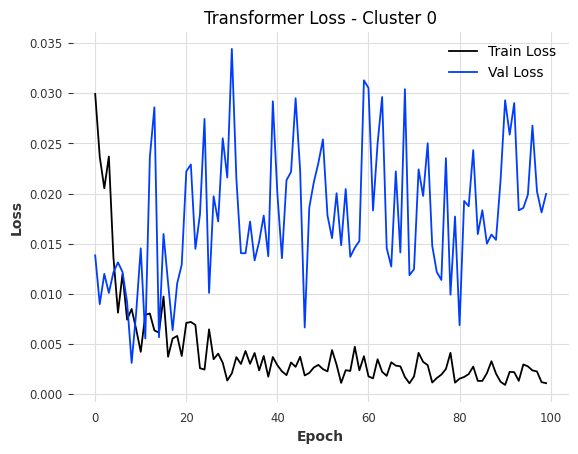

In [17]:
class LossRecorder_transformer(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_transformer = LossRecorder_transformer()


model_name = "Transformer_test"
model_transformer = TransformerModel(
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_transformer]}
    # **generate_torch_kwargs()
)

model_transformer.fit(
    series=train_lists_c0,
    past_covariates=covariates_lists_c0,
    val_series=val_lists_c0,
    val_past_covariates=covariates_lists_c0,
)

model_transformer = TransformerModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_transformer.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_transformer.val_loss_history, label='Val Loss')
plt.title('Transformer Loss - Cluster 0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
model_transformer

TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, batch_size=8, n_epochs=100, random_state=1, input_chunk_length=24, output_chunk_length=12, model_name=Transformer_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossRecorder_transformer object at 0x7fe83450d1e0>]})

Predicting: |          | 0/? [00:00<?, ?it/s]

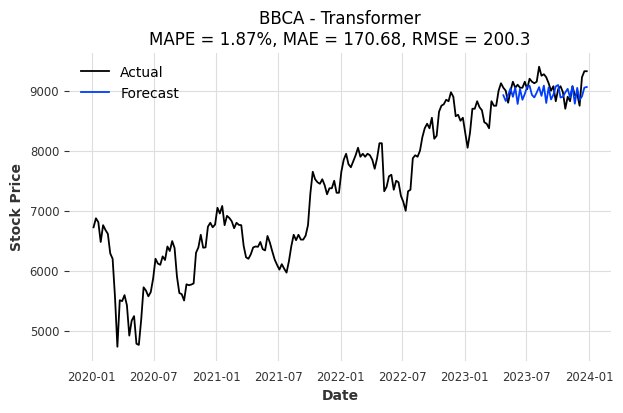

Predicting: |          | 0/? [00:00<?, ?it/s]

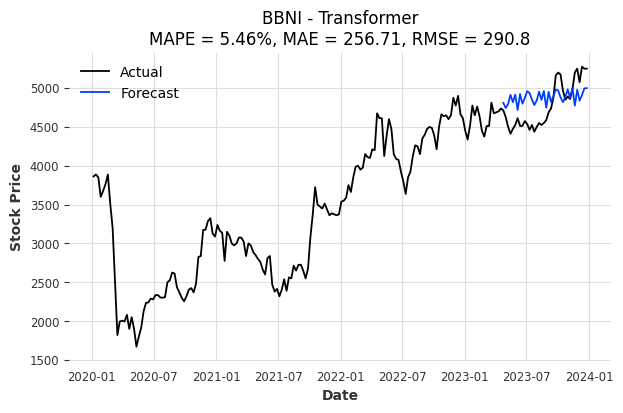

Predicting: |          | 0/? [00:00<?, ?it/s]

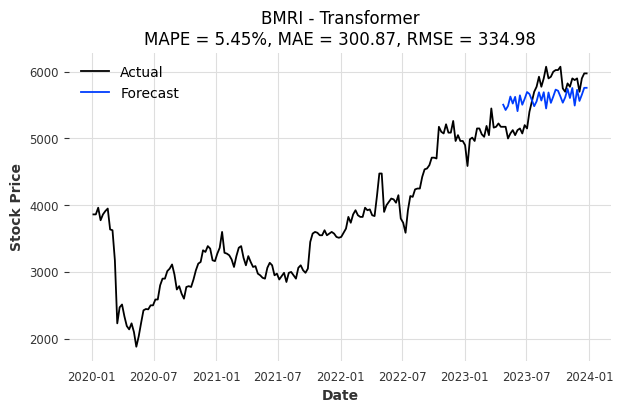

In [19]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c0, val_lists_c0, scalers_lists_c0, labels_c0, covariates_lists_c0, df_lists_c0):
    predict_pastcov(train_data=train, val_data=val,
                   model=model_transformer, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='Transformer')

#### 3) No Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

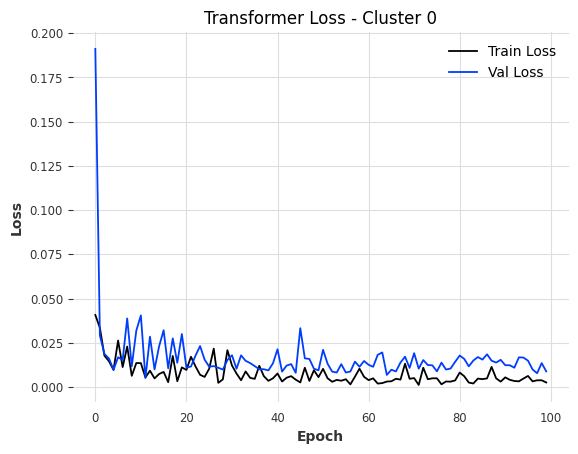

In [20]:
class LossRecorder_transformer(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_transformer = LossRecorder_transformer()


model_name = "Transformer_test"
model_transformer = TransformerModel(
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_transformer]}
    # **generate_torch_kwargs()
)

model_transformer.fit(
    series=train_lists_c0,
    val_series=val_lists_c0,
)

model_transformer = TransformerModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_transformer.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_transformer.val_loss_history, label='Val Loss')
plt.title('Transformer Loss - Cluster 0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predicting: |          | 0/? [00:00<?, ?it/s]

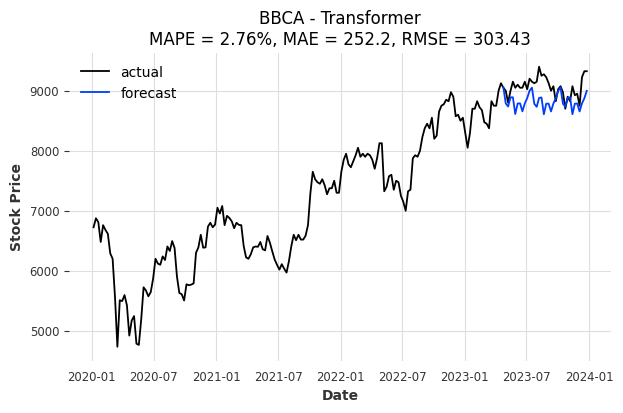

Predicting: |          | 0/? [00:00<?, ?it/s]

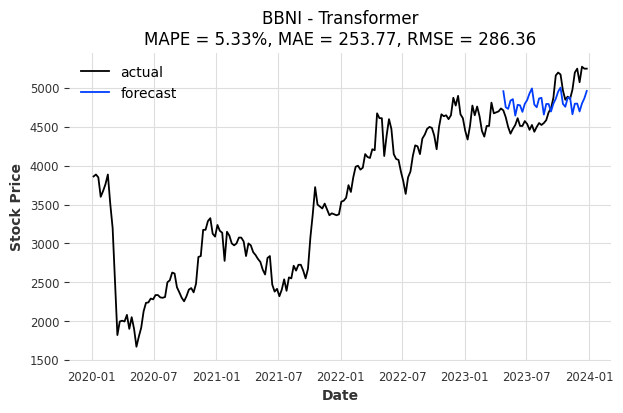

Predicting: |          | 0/? [00:00<?, ?it/s]

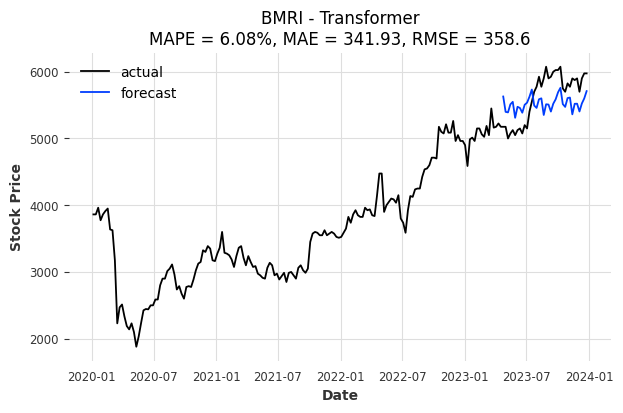

In [21]:
# Loop through the training, validation, and lists
for train, val, scaler, stock, df in zip(train_lists_c0, val_lists_c0, scalers_lists_c0, labels_c0, df_lists_c0):
    predict_nocov(train_data=train, val_data=val,
                   model=model_transformer, scaler=scaler,
                   stock_name=stock, df=df, model_name='Transformer')

## c) Model Training - Cluster 1

#### 1) With All Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

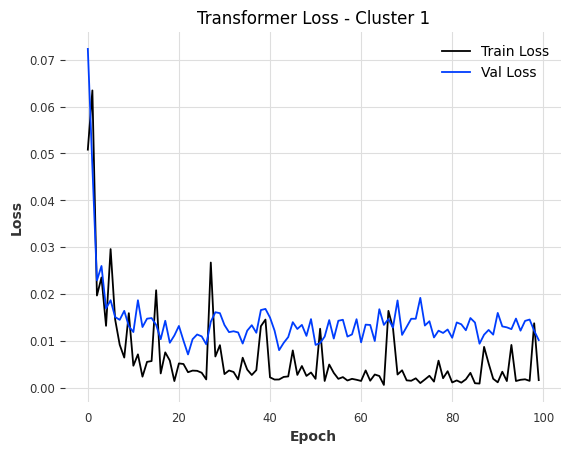

In [22]:
class LossRecorder_transformer(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_transformer = LossRecorder_transformer()


model_name = "Transformer_test"
model_transformer = TransformerModel(
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_transformer]}
    # **generate_torch_kwargs()
)

model_transformer.fit(
    series=train_lists_c1_all,
    past_covariates=covariates_lists_c1_all,
    val_series=val_lists_c1_all,
    val_past_covariates=covariates_lists_c1_all,
)

model_transformer = TransformerModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_transformer.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_transformer.val_loss_history, label='Val Loss')
plt.title('Transformer Loss - Cluster 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model_transformer

TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, batch_size=8, n_epochs=100, random_state=1, input_chunk_length=24, output_chunk_length=12, model_name=Transformer_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossRecorder_transformer object at 0x7fe82fbce170>]})

Predicting: |          | 0/? [00:00<?, ?it/s]

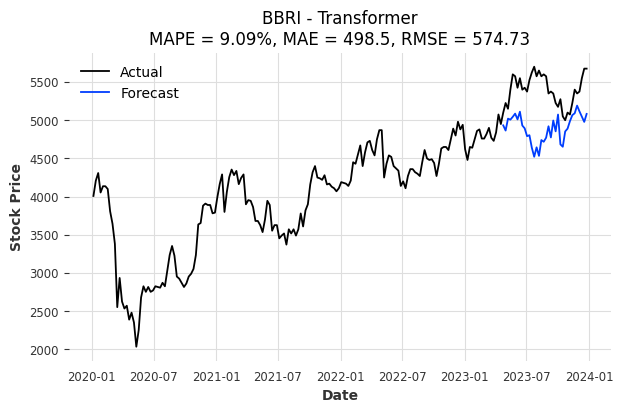

Predicting: |          | 0/? [00:00<?, ?it/s]

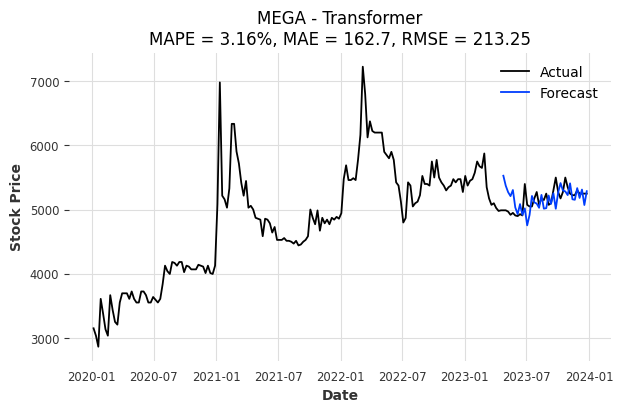

In [24]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c1_all, val_lists_c1_all, scalers_lists_c1_all, labels_c1, covariates_lists_c1_all, df_lists_c1_all):
    predict_pastcov(train_data=train, val_data=val,
                   model=model_transformer, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='Transformer')

#### 2) With Shapley Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

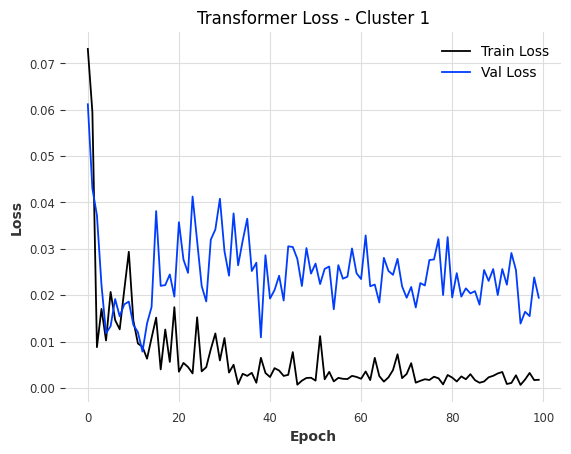

In [25]:
class LossRecorder_transformer(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_transformer = LossRecorder_transformer()


model_name = "Transformer_test"
model_transformer = TransformerModel(
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_transformer]}
    # **generate_torch_kwargs()
)

model_transformer.fit(
    series=train_lists_c1,
    past_covariates=covariates_lists_c1,
    val_series=val_lists_c1,
    val_past_covariates=covariates_lists_c1,
)

model_transformer = TransformerModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_transformer.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_transformer.val_loss_history, label='Val Loss')
plt.title('Transformer Loss - Cluster 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
model_transformer

TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, batch_size=8, n_epochs=100, random_state=1, input_chunk_length=24, output_chunk_length=12, model_name=Transformer_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossRecorder_transformer object at 0x7fe82fcf31f0>]})

Predicting: |          | 0/? [00:00<?, ?it/s]

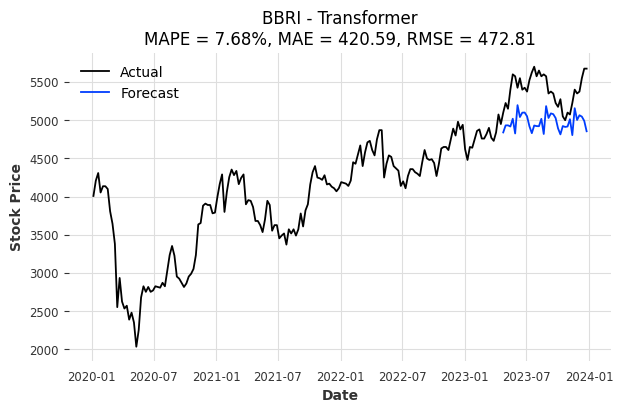

Predicting: |          | 0/? [00:00<?, ?it/s]

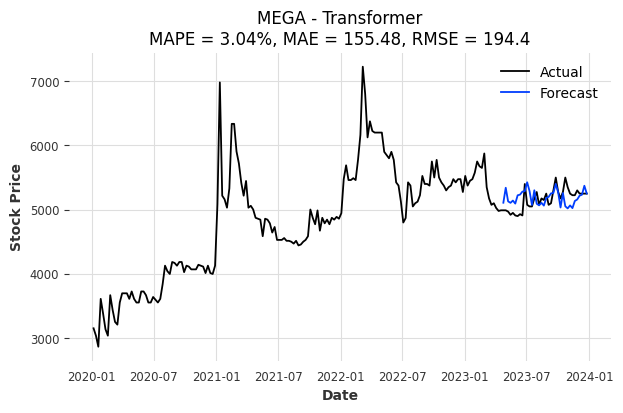

In [27]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c1, val_lists_c1, scalers_lists_c1, labels_c1, covariates_lists_c1, df_lists_c1):
    predict_pastcov(train_data=train, val_data=val,
                   model=model_transformer, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='Transformer')

#### 3) No Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

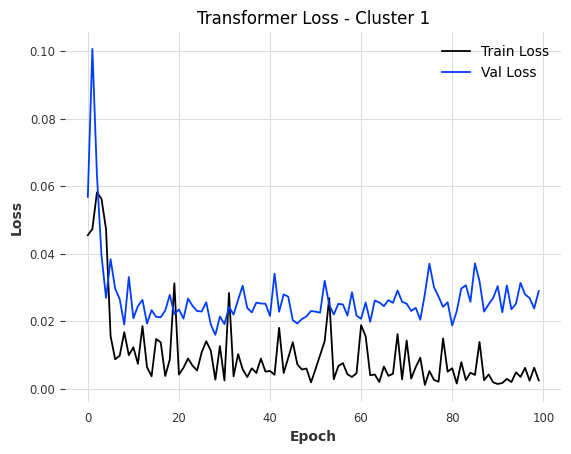

In [28]:
class LossRecorder_transformer(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_transformer = LossRecorder_transformer()


model_name = "Transformer_test"
model_transformer = TransformerModel(
    batch_size=8,
    n_epochs=100,
    random_state=1,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_transformer]}
    # **generate_torch_kwargs()
)

model_transformer.fit(
    series=train_lists_c1,
    val_series=val_lists_c1,
)

model_transformer = TransformerModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_transformer.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_transformer.val_loss_history, label='Val Loss')
plt.title('Transformer Loss - Cluster 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predicting: |          | 0/? [00:00<?, ?it/s]

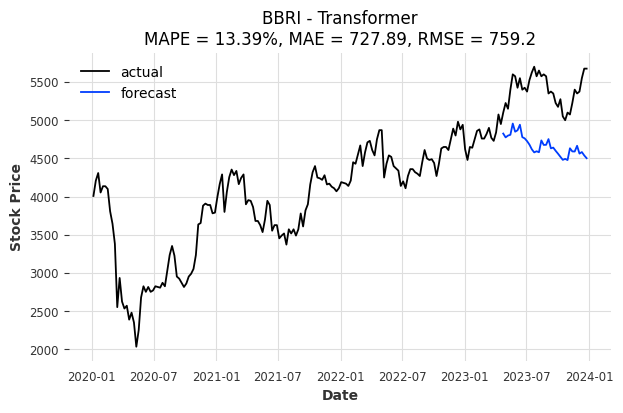

Predicting: |          | 0/? [00:00<?, ?it/s]

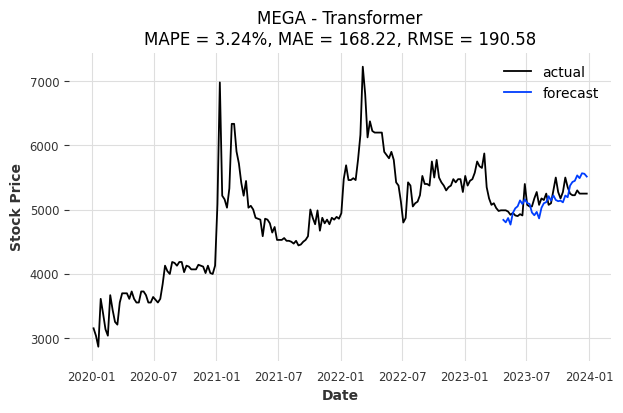

In [29]:
# Loop through the training, validation, and lists
for train, val, scaler, stock, df in zip(train_lists_c1, val_lists_c1, scalers_lists_c1, labels_c1, df_lists_c1):
    predict_nocov(train_data=train, val_data=val,
                   model=model_transformer, scaler=scaler,
                   stock_name=stock, df=df, model_name='Transformer')